# Filter Comparison

Comparing effective area curves for various filter combinations.

In [1]:
import astropy.units as u
import astropy.constants as const
from astropy.visualization import quantity_support
import matplotlib.pyplot as plt
import numpy as np
from mocksipipeline.detector.response import Channel, ThinFilmFilter, SpectrogramChannel
import xrtpy

In [2]:
polymide_thick = ThinFilmFilter(elements=['C','H','N','O'],
                          quantities=[22,10,2,5],
                          density=1.43*u.g/u.cm**3,
                          thickness = 1*u.micron)
polymide_thin = ThinFilmFilter(elements=['C','H','N','O'],
                          quantities=[22,10,2,5],
                          density=1.43*u.g/u.cm**3,
                          thickness = 100*u.nm)
al_thin = ThinFilmFilter(elements='Al', thickness=100*u.nm)
al_thick = ThinFilmFilter(elements='Al', thickness=200*u.nm)

## Dispersed Channel

In [3]:
configs = [
    al_thin,
    al_thick,
    [al_thin, polymide_thin],
    [al_thick, polymide_thin],
]

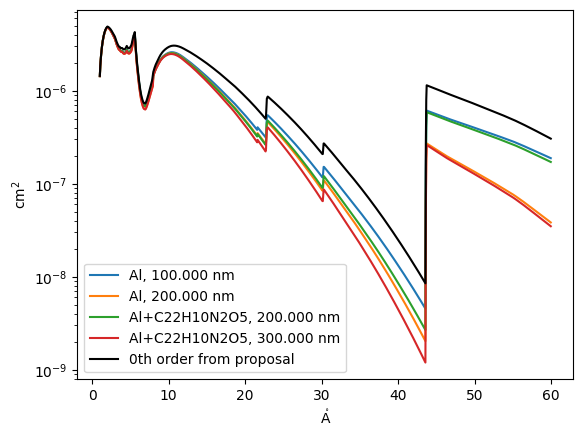

In [4]:
fig = plt.figure()
ax = fig.add_subplot()
with quantity_support():
    for f in configs:
        chan = SpectrogramChannel(0, f)
        ax.plot(chan.wavelength, chan.effective_area, label=chan.filter_label)
    struc = chan._instrument_data['SAVEGEN0'][chan._data_index]
    ax.plot(struc['WAVE']*u.angstrom, struc['EFFAREA']*u.cm**2, label='0th order from proposal', color='k')
ax.set_yscale('log')
ax.legend()

## Filtergrams

In [5]:
configs = [
    [al_thin, polymide_thick],
    [al_thick, polymide_thick],
    [ThinFilmFilter('Be', thickness=9*u.micron)],
    [ThinFilmFilter('Be', thickness=30*u.micron)],
    [ThinFilmFilter('Be', thickness=300*u.micron)],
]

In [6]:
eaf = xrtpy.response.EffectiveAreaFundamental('Al_poly', '2020-01-01') 

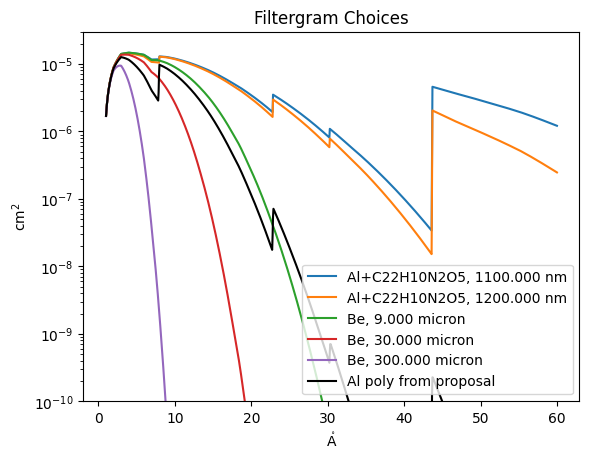

In [7]:
fig = plt.figure()
ax = fig.add_subplot()
with quantity_support():
    for f in configs:
        chan = Channel('filtergram_1', f)
        ax.plot(chan.wavelength, chan.effective_area, label=chan.filter_label)
    struc = chan._instrument_data['SAVEGEN0'][chan._index_mapping['Al_poly']]
    # from MOXSI proposal
    ax.plot(struc['WAVE']*u.angstrom, struc['EFFAREA']*u.cm**2, label='Al poly from proposal', color='k')
ax.set_yscale('log')
ax.set_ylim(1e-10,3e-5)
ax.set_title('Filtergram Choices')
ax.legend()

The plot below shows just the filter transmission and compares it with the Al-poly channel on XRT. We have extended the response out to 150 Å to understand how longer wavelengths will respond to our bandpass as well which is important for the 0th order (and the filtergrams).

In [14]:
def combine_filter_transmission(filters, wavelength):
    energy = const.h * const.c / wavelength
    ft = u.Quantity(np.ones(energy.shape))
    for f in filters:
        ft *= f.transmissivity(energy)
    return ft

In [15]:
wavelength = np.arange(.5, 150, 0.055) * u.Angstrom

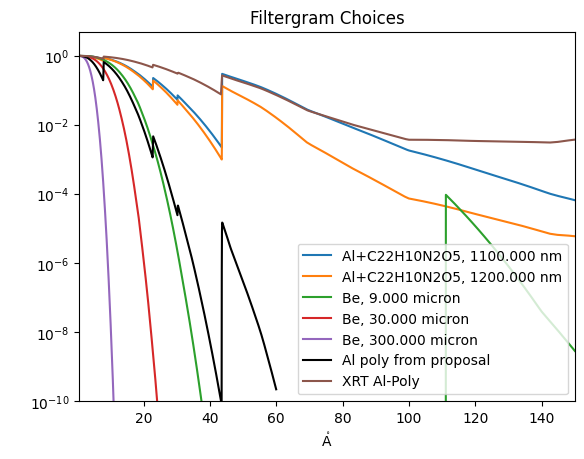

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
with quantity_support():
    for f in configs:
        chan = Channel('filtergram_1', f)
        trans = combine_filter_transmission(f, wavelength)
        ax.plot(wavelength, trans, label=chan.filter_label)
    struc = chan._instrument_data['SAVEGEN0'][chan._index_mapping['Al_poly']]
    # from MOXSI proposal
    ax.plot(struc['WAVE']*u.angstrom, struc['FILTER'], label='Al poly from proposal', color='k')
    # from xrtpy
    xrt_filter = xrtpy.response.Channel('Al-poly').filter_1
    ax.plot(xrt_filter.filter_wavelength, xrt_filter.filter_transmission, label='XRT Al-Poly')
ax.set_yscale('log')
ax.set_ylim(1e-10,5)
ax.set_xlim(wavelength[[0,-1]])
ax.set_title('Filtergram Choices')
ax.legend()

## Filter Summary

The figure below puts all of the channels, for both the filtergrams and the dispersed channels, on the same plot for our current conception of the filter designs.

In [17]:
filtergrams = [
    Channel('filtergram_1', [ThinFilmFilter('Be', thickness=9*u.micron)]),
    Channel('filtergram_2', [ThinFilmFilter('Be', thickness=30*u.micron)]),
    Channel('filtergram_3', [ThinFilmFilter('Be', thickness=300*u.micron)]),
    Channel('filtergram_4', [polymide_thick, al_thin]),
]
dispersed_channels = [
    SpectrogramChannel(0, [al_thin]),
    SpectrogramChannel(1, [al_thin]),
    SpectrogramChannel(3, [al_thin]),
]

Text(0, 0.5, 'Effective Area [cm$^2$]')

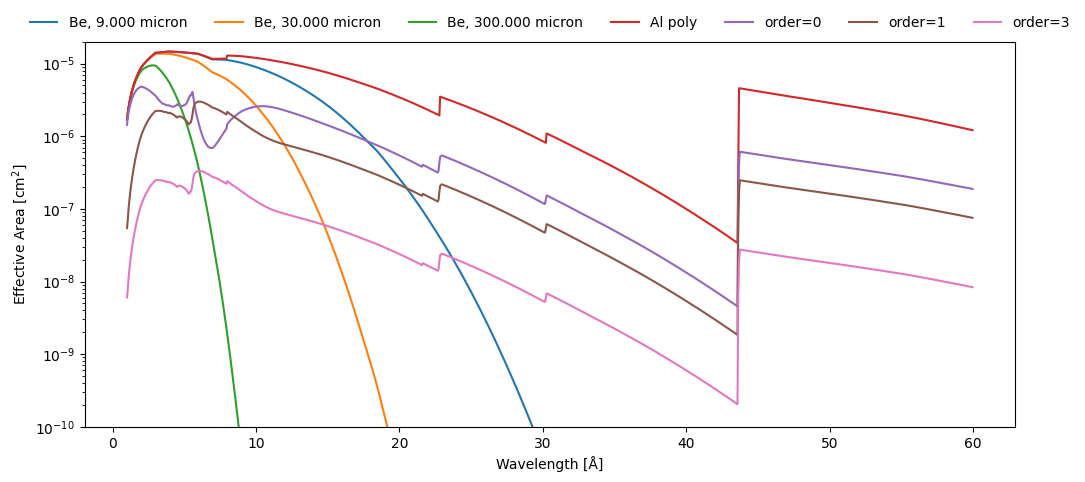

In [18]:
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot()
for f in filtergrams:
    ax.plot(f.wavelength, f.effective_area, label='Al poly' if 'Al' in f.filter_label else f.filter_label)
for f in dispersed_channels:
    ax.plot(f.wavelength, f.effective_area, label=f'order={f.spectral_order}')
ax.set_yscale('log')
ax.set_ylim(1e-10,2e-5)
ax.legend(bbox_to_anchor=(.5,1.05), loc='center', ncol=7,frameon=False)
ax.set_xlabel('Wavelength [Å]')
ax.set_ylabel('Effective Area [cm$^2$]')

## Detector Efficiency

Below, I'm just doing a few experiements to try to understand how the detector efficiency was modeled.
It appears that it is just the absorption in Si for some particular thickness and interpolated poorly to a wavelength array corresponding to the bandpass.
I still do not understand why the thickness is approximately 33 microns.

In [19]:
si_thinfilm = ThinFilmFilter('Si', thickness=33*u.micron)

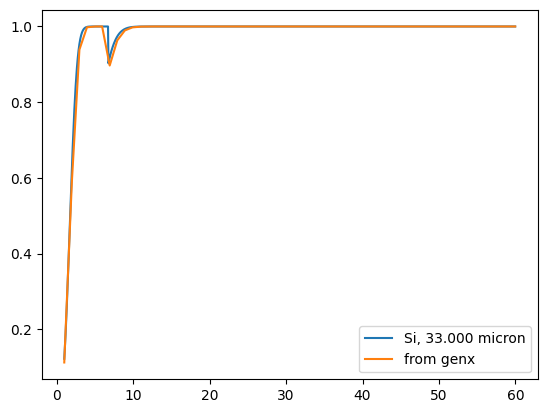

In [20]:
si_trans = si_thinfilm.transmissivity(const.h * const.c / chan.wavelength)
si_absor = 1-si_trans
plt.plot(chan.wavelength,si_absor, label=Channel('filtergram_1',si_thinfilm).filter_label)
plt.plot(struc['WAVE'], struc['DET'], label='from genx')
plt.legend()

In [21]:
si_thinfilm.density_normalized.to('g cm-3')

<Quantity 2.32964147 g / cm3>

This model clearly differs a bit from what is stored in that file, but it is not clear to what extent this is just due to interpolation (and maybe a poor estimate of what type of material is used).

Text(0.5, 1.0, 'Relative Difference')

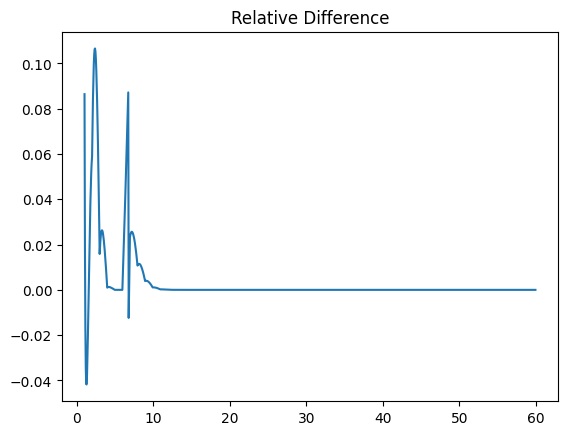

In [23]:
plt.plot(chan.wavelength, si_absor / struc['DET'] - 1)
plt.title('Relative Difference')